# How to access Sentinel Hub Public Collections

This example notebook has been written to demonstrate how to access and make requests to the Sentinel Hub Public Collections.

There are four examples:
1. [Accessing the Sentinels, Landsat, DEM and MODIS Collections](#The-Sentinels,-Landsat,-DEM-and-MODIS-Collections)
2. [Accessing BYOC Collections](#BYOC-collections)
3. [Accessing Copernicus Services Collections](#Example:-3-Copernicus-Services-Data)
4. [Accessing Commercial Collections](#Commercial-Collections)

Firstly, we import the relevant Python packages to proceed:  
If sentinelhub library is not installed, run the command `$ pip install sentinelhub` to install.

In [1]:
from sentinelhub import (
    SHConfig, CRS, BBox,
    MimeType, bbox_to_dimensions,
    DataCollection, 
    SentinelHubRequest)
import matplotlib.pyplot as plt

 

c:\Users\mkampen\anaconda3\envs\shpy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we configure our credentials to access Sentinel Hub services. For more information on setting these up you can check out the relevant [documentation](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/) page. 

In [2]:
# Set up credentials
config = SHConfig()

# If you haven't saved your config, uncomment teh lines below and specify client id and client secret
# config.sh_client_id = '<your client id>'
#config.sh_client_secret = '<your client secret>'

Next, we define the bounding box that we will use for this example. First the coordinates and resolution are defined. Then using the `BBox` and `bbox_to_dimensions` functions we define the AOI for our data requests. 

In [3]:
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]

resolution = 30
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

## The Sentinels, Landsat, DEM and MODIS Collections
The Sentinels, Landsat, DEM and MODIS collections have been predefined in sentinelhub py `DataCollection` class. On [Sentinel Hub Public Collections](https://collections.sentinel-hub.com/) page, these collections' `Type` starts without `byoc-`. E.g., [Copernicus DEM](https://collections.sentinel-hub.com/copernicus-dem/), [Landsat-8 L1](https://collections.sentinel-hub.com/landsat-8-l1/), [Sentinel-1 GRD](https://collections.sentinel-hub.com/sentinel-1-grd/), [Sentinel-2 L2A](https://collections.sentinel-hub.com/sentinel-2-l2a/) etc. Please refer to the [DataCollection documentation](https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.data_collections.html#sentinelhub.data_collections.DataCollection) for the corresponding attributes of `DataCollection` based on the `Type` listed on the page.

### Example 1: Sentinel-2 L2A

Let's start off by defining the evalscript we use to request and visualise the Sentinel-2 True Color image. More about writing evalscripts can be found [here](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).

In [4]:
true_color_evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { 
      bands: 3, 
      sampleType: "AUTO" // default value - scales the output values from [0,1] to [0,255].
    }
  }
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02] // multiplied by a factor of 2.5 to increase brightness
}
"""

After defining the evalscript, we can then use this in our request payload. You can see that the Data Collection is named as `DataCollection.SENTINEL2_L2A`. If we were requesting the Sentinel-2 L1C it would be `DataCollection.SENTINEL2_L1C`. More information about the Sentinel and other datasets available at Sentinel Hub can be found [here](https://docs.sentinel-hub.com/api/latest/data/).

We build the request payload according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Process API request also needs an evalscript.

The information that we specify in the SentinelHubRequest object is:

an evalscript,

a list of input data collections with time interval,

a format of the response,

a bounding box and it’s size (size or resolution).

In [5]:
request_true_color = SentinelHubRequest(
    evalscript=true_color_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2022-08-02', '2022-09-02'),
            mosaicking_order="leastCC"
        )
    ],
    responses=[
        SentinelHubRequest.output_response(
            "default", MimeType.PNG
        )
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [6]:
true_color_imgs = request_true_color.get_data()

true_color_img = true_color_imgs[0]

Now we can plot the image using Matplotlib:

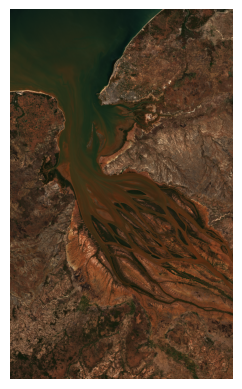

In [7]:
plt.axis("off")
plt.imshow(true_color_img)

## BYOC Collections
BYOC collections are data collections that have been ingested to Sentinel Hub for public access using Sentinel Hub Bring Your Own COG service ([BYOC](https://docs.sentinel-hub.com/api/latest/api/byoc/)). For these collections on [Sentinel Hub Public Collections](https://collections.sentinel-hub.com/) page, the Resources section provides `collectionId`,`Endpoint` and  `Type` which start with `byoc-` . For example, [Sentinel-2 L2A 120m Mosaic](https://collections.sentinel-hub.com/sentinel-s2-l2a-mosaic-120/), [ESA WorldCover](https://collections.sentinel-hub.com/worldcover/), etc. Note that these collections can be deployed on different endpoints, which need to be specified when requesting the data.

### Example 2: Sentinel-2 L2A 120m Mosaic

In this example we will request the Sentinel-2 L2A 120m Mosaic deployed on `services.sentinel-hub.com`: 

- End point: `services.sentinel-hub.com`
- Type: `byoc-484d8dbb-9e3e-41f2-b96b-35189d3ae37f`
- collectionId: `484d8dbb-9e3e-41f2-b96b-35189d3ae37f`

As `services.sentinel-hub.com` is the default end point for deployment, there's no need to specify `sh_base_url` when requesting data.

In [8]:
s2l2a_120m_mosaic = DataCollection.define_byoc(
    collection_id="484d8dbb-9e3e-41f2-b96b-35189d3ae37f"
)

We define the evalscript and then the payload:

In [9]:
false_color_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08","B04","B03", "dataMask"],
    output: { bands: 4 },
  };
}

var f = 2.5/10000;
function evaluatePixel(sample) {
  return [f*sample.B08, f*sample.B04, f*sample.B03, sample.dataMask];
}
"""

In [10]:
time_interval_120m_mosaic = ("2020-01-01", "2020-12-31")
betsiboka_size_120m = bbox_to_dimensions(
    betsiboka_bbox, resolution=120)

In [11]:
request_120m_mosaic = SentinelHubRequest(
    evalscript=false_color_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=s2l2a_120m_mosaic, time_interval=time_interval_120m_mosaic)
    ],
    responses=[
        SentinelHubRequest.output_response(
            "default", MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size_120m,
    config=config,
)

In [12]:
false_color_imgs = request_120m_mosaic.get_data()

false_color_image = false_color_imgs[0]

And then can plot the requested data collection:

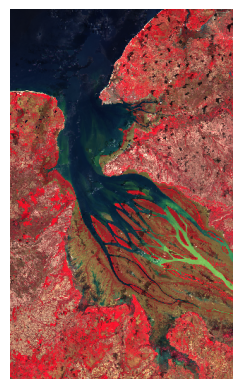

In [13]:
plt.axis("off")
plt.imshow(false_color_image)

### Copernicus Services Data
Several Copernicus Services data have been ingested to Sentinel Hub using Sentinel Hub BYOC service. These include [CORINE Land Cover](https://collections.sentinel-hub.com/corine-land-cover/), [Global Surface Water](https://collections.sentinel-hub.com/global-surface-water/) etc. Most of these data are deployed on `creodias.sentinel-hub.com`, and this is indicated on the Resources section of the collections on [Public Colections](https://collections.sentinel-hub.com/) page

#### Example 3: Corine Land Cover Data

This is an example to access Corine Land Cover Data deployed on CreoDIAS
- End point: `creodias.sentinel-hub.com`
- Type: `byoc-cbdba844-f86d-41dc-95ad-b3f7f12535e9`
- collectionId: `cbdba844-f86d-41dc-95ad-b3f7f12535e9`

As the data collection is deployed on `CREODIAS`, the `sh_base_url` needs to be specified to access the data.


In [14]:
config.sh_base_url = "https://creodias.sentinel-hub.com"
corine_land_cover = DataCollection.define_byoc(
    collection_id="cbdba844-f86d-41dc-95ad-b3f7f12535e9"
)

We define the evalscript and then the payload:

In [15]:
corine_land_cover_visualisation_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC", "dataMask"],
    output: { 
      bands: 4, 
      sampleType: "AUTO"
    }
  }
}

const map = [
    [1, 0xe6004d],  //111 - Continuous urban fabric
    [2, 0xff0000],  //112 - Discontinuous urban fabric
    [3, 0xcc4df2],  //121 - Industrial or commercial units
    [4, 0xcc0000],  //122 - Road and rail networks and associated land
    [5, 0xe6cccc],  //123 - Port areas
    [6, 0xe6cce6],  //124 - Airports
    [7, 0xa600cc],  //131 - Mineral extraction sites
    [8, 0xa64d00],  //132 - Dump sites
    [9, 0xff4dff],  //133 - Construction sites
    [10, 0xffa6ff], //141 - Green urban areas
    [11, 0xffe6ff], //142 - Sport and leisure facilities
    [12, 0xffffa8], //211 - Non-irrigated arable land
    [13, 0xffff00], //212 - Permanently irrigated land
    [14, 0xe6e600], //213 - Rice fields
    [15, 0xe68000], //221 - Vineyards
    [16, 0xf2a64d], //222 - Fruit trees and berry plantations
    [17, 0xe6a600], //223 - Olive groves
    [18, 0xe6e64d], //231 - Pastures
    [19, 0xffe6a6], //241 - Annual crops associated with permanent crops
    [20, 0xffe64d], //242 - Complex cultivation patterns
    [21, 0xe6cc4d], //243 - Land principally occupied by agriculture with significant areas of natural vegetation
    [22, 0xf2cca6], //244 - Agro-forestry areas
    [23, 0x80ff00], //311 - Broad-leaved forest
    [24, 0x00a600], //312 - Coniferous forest
    [25, 0x4dff00], //313 - Mixed forest
    [26, 0xccf24d], //321 - Natural grasslands
    [27, 0xa6ff80], //322 - Moors and heathland
    [28, 0xa6e64d], //323 - Sclerophyllous vegetation
    [29, 0xa6f200], //324 - Transitional woodland-shrub
    [30, 0xe6e6e6], //331 - Beaches - dunes - sands
    [31, 0xcccccc], //332 - Bare rocks
    [32, 0xccffcc], //333 - Sparsely vegetated areas
    [33, 0x000000], //334 - Burnt areas
    [34, 0xa6e6cc], //335 - Glaciers and perpetual snow
    [35, 0xa6a6ff], //411 - Inland marshes
    [36, 0x4d4dff], //412 - Peat bogs
    [37, 0xccccff], //421 - Salt marshes
    [38, 0xe6e6ff], //422 - Salines
    [39, 0xa6a6e6], //423 - Intertidal flats
    [40, 0x00ccf2], //511 - Water courses
    [41, 0x80f2e6], //512 - Water bodies
    [42, 0x00ffa6], //521 - Coastal lagoons
    [43, 0xa6ffe6], //522 - Estuaries
    [44, 0xe6f2ff], //523 - Sea and ocean
    [48, 0xffffff]  //999 - NODATA
  ];

const visualizer = new ColorMapVisualizer(map);

function evaluatePixel(sample) {
  return [visualizer.process(sample.CLC)[0], visualizer.process(sample.CLC)[1], visualizer.process(sample.CLC)[2], sample.dataMask];
}
"""

In this example, we are using a different bounding box, and are also requesting a certain year of the CORINE Land Cover so we have defined some additional variables.

In [16]:
time_interval_corine_land_cover = ("2018-01-01", "2018-12-31")
graz_bbox = BBox(bbox=[15.076032, 46.777493,15.792842, 47.282956], crs=CRS.WGS84)
graz_size_100m = bbox_to_dimensions(
    graz_bbox, resolution=100)

In [17]:
request_corine_land_cover = SentinelHubRequest(
    evalscript=corine_land_cover_visualisation_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=corine_land_cover, 
            time_interval=time_interval_corine_land_cover)
    ],
    responses=[
        SentinelHubRequest.output_response(
            "default", MimeType.PNG)
    ],
    bbox=graz_bbox,
    size=graz_size_100m,
    config=config,
)

In [18]:
corine_land_cover_imgs = request_corine_land_cover.get_data()

corine_land_cover_image = corine_land_cover_imgs[0]

Now we can plot the image using Matplotlib:

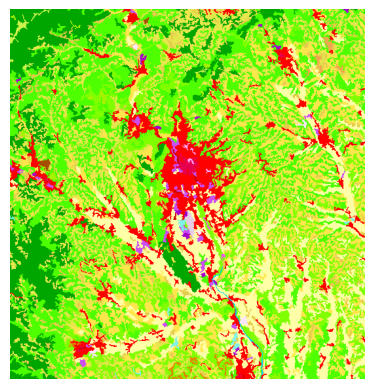

In [19]:
plt.axis("off")
plt.imshow(corine_land_cover_image[..., :-1])

## Commercial Collections

Sentinel Hub supports ordering of data provided by commercial data providers. After a successful order, data is ingested to Sentinel Hub and can be accessed like any other BYOC collection.
Currently Sentinel Hub supports the following commercial data:

- Planet's [PlanetScope](https://docs.sentinel-hub.com/api/latest/data/planet/planet-scope/) data
- Planet's [SkySat](https://docs.sentinel-hub.com/api/latest/data/planet/skysat/) data
- Airbus's [Pleiades](https://docs.sentinel-hub.com/api/latest/data/airbus/pleiades/) data
- Airbus's [SPOT](https://docs.sentinel-hub.com/api/latest/data/airbus/spot/) data
- Maxar's [WorldView](https://docs.sentinel-hub.com/api/latest/data/maxar/world-view/) data



### Example 4: WorldView data

This is an example to access WorldView data.
- End Point: `services.sentinel-hub.com`
- Type: `byoc-991fe3be-4d19-4d9f-9941-879da0a5c3b3`
- collectionId: `991fe3be-4d19-4d9f-9941-879da0a5c3b3`

Note that you have to order and purchase data for it to be available in your Sentinel Hub account.
When your WorldView data is imported into Sentinel Hub, you will receive the collection ID, with which you need to replace the collection ID `991fe3be-4d19-4d9f-9941-879da0a5c3b3` used in the examples in `data_collection=DataCollection.define_byoc('991fe3be-4d19-4d9f-9941-879da0a5c3b3')`. You will also need to adjust the values of bounds and timeRange parameters, so that they correspond to your data.

The example worldview collection is deployed on Sentinel Hub, so we set the `sh_base_url` back to the default setting `https://services.sentinel-hub.com` and define a BYOC collection using the collection ID.

In [20]:
config.sh_base_url = "https://services.sentinel-hub.com"
worldview = DataCollection.define_byoc('991fe3be-4d19-4d9f-9941-879da0a5c3b3')

We define the evalscript and then the payload:

In [21]:
worldview_true_color = """
//VERSION=3
function setup() {
  return {
    input: [{
      "bands": ["Red", "Green", "Blue", "dataMask"]
    }],
    output: {
      bands: 4
    }
  }
}
function evaluatePixel(sample) {
  return [
    2.5 * sample.Red / 10000,
    2.5 * sample.Green / 10000,
    2.5 * sample.Blue / 10000,
    sample.dataMask
  ]
}
"""

In this example, the bounding box and the time range are specifically set for the sample of WorldView data.  

In [22]:
time_interval_worldview = ('2020-11-06', '2020-11-06')
worldview_bbox = BBox(
    bbox=[561924.43, 5172145.65, 564217.92, 5174392.08], crs=CRS.UTM_33N)
worldview_size_2m = bbox_to_dimensions(
    worldview_bbox, resolution=2)

In [23]:
request_worldview = SentinelHubRequest(
    evalscript=worldview_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=worldview,          
            time_interval=time_interval_worldview,          
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG),
    ],
    bbox=worldview_bbox,
    size=worldview_size_2m,
    config=config
)

In [24]:
worldview_imgs = request_worldview.get_data()

worldview_image = worldview_imgs[0]

Then we can plot the sample WorldView data:

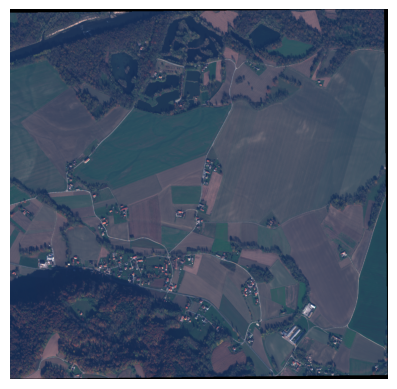

In [25]:
plt.axis("off")
plt.imshow(worldview_image[..., :-1])

That concludes this notebook, and you should now fully understand how to access the different types of data collections available on Sentinel Hub Public Collections!

If you need more support you can always contact us on the [Sentinel Hub Forum](https://forum.sentinel-hub.com/). 